# Viewing images of Varchamp wells
**Author:** Jessica Ewald <br>

The purpose of this script is to query image names by batch, plate, well, site, & channel, download from AWS, and render in a notebook. This will be useful for quick visual sanity checks.

In [6]:
# Imports
import polars as pl
import numpy as np
from sh import aws
import os
from skimage.io import imread
from matplotlib import pyplot as plt
import matplotlib as mpl

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# get sample metadata
dat = pl.scan_parquet(
    "/dgx1nas1/storage/data/jess/varchamp/sc_data/processed_profiles/Rep_Ctrls/annotated_normalized_featselected.parquet"
)

meta_cols = [i for i in dat.columns if "Metadata_" in i]

dat = dat.select(meta_cols).collect()

In [3]:
dat.filter(pl.col("Metadata_allele").is_in(["ALK_", "ALK_R1275Q"])).select(
    ["Metadata_Well", "Metadata_allele"]
).unique().head

<bound method DataFrame.head of shape: (96, 2)
┌───────────────┬─────────────────┐
│ Metadata_Well ┆ Metadata_allele │
│ ---           ┆ ---             │
│ str           ┆ str             │
╞═══════════════╪═════════════════╡
│ L15           ┆ ALK_            │
│ H10           ┆ ALK_            │
│ E19           ┆ ALK_R1275Q      │
│ I24           ┆ ALK_            │
│ P23           ┆ ALK_R1275Q      │
│ …             ┆ …               │
│ K18           ┆ ALK_R1275Q      │
│ E13           ┆ ALK_R1275Q      │
│ F19           ┆ ALK_R1275Q      │
│ C21           ┆ ALK_R1275Q      │
│ I14           ┆ ALK_R1275Q      │
└───────────────┴─────────────────┘>

In [90]:
# Define mapping between simple names and folder names
batch_dict = {"B4A3R1": "2023-12-15_B4A3R1", 
              "B6A3R2": "2023-12-21_B6A3R2", 
              "B7A1R1": "2024_01_23_Batch_7",
              "B8A1R2": "2024_02_06_Batch_8"}

letter_dict = {
    "A": "01",
    "B": "02",
    "C": "03",
    "D": "04",
    "E": "05",
    "F": "06",
    "G": "07",
    "H": "08",
    "I": "09",
    "J": "10",
    "K": "11",
    "L": "12",
    "M": "13",
    "N": "14",
    "O": "15",
    "P": "16",
}

plate_dict = {
    "B4-P1T1": "2023-12-15_B4A3R1_P1T1__2023-12-15T08_49_02-Measurement1",
    "B4-P1T2": "2023-12-15_B4A3R1_P1T2__2023-12-15T10_35_54-Measurement1",
    "B4-P1T3": "2023-12-18_B4A3R1_P1T3__2023-12-18T08_29_45-Measurement1",
    "B4-P1T4": "2023-12-18_B4A3R1_P1T4__2023-12-18T10_17_07-Measurement1",
    
    "B6-P1T1": "2023-12-21_B6A3R2_P1T1__2023-12-21T08_28_37-Measurement1",
    "B6-P1T2": "2023-12-21_B6A3R2_P1T2__2023-12-21T10_11_34-Measurement1",
    "B6-P1T3": "2023-12-21_B6A3R2_P1T3__2023-12-21T11_57_14-Measurement1",
    "B6-P1T4": "2023-12-21_B6A3R2_P1T4__2023-12-21T13_40_04-Measurement1",
    
    "B7-P1T1": "2024_01_17_B7A1R1_P1T1__2024_01_17T08_35_58_Measurement_1",
    "B7-P1T2": "2024_01_17_B7A1R1_P1T2__2024_01_17T10_13_45_Measurement_1",
    "B7-P1T3": "2024_01_17_B7A1R1_P1T3__2024_01_17T11_58_08_Measurement_1",
    "B7-P1T4": "2024_01_17_B7A1R1_P1T4__2024_01_17T13_45_14_Measurement_1",
    
    "B7-P3T1": "2024_01_18_B7A1R1_P3T1__2024_01_18T14_27_08_Measurement_1",
    "B7-P3T2": "2024_01_19_B7A1R1_P3T2__2024_01_19T08_23_30_Measurement_1",
    "B7-P3T3": "2024_01_19_B7A1R1_P3T3__2024_01_19T10_01_45_Measurement_1",
    "B7-P3T4": "2024_01_19_B7A1R1_P3T4__2024_01_19T12_00_10_Measurement_1",
    
    "B7-A2T1": "2024_01_22_B7A2R1_P1T1__2024_01_22T12_13_13_Measurement_1",
    "B7-A2T2": "2024_01_22_B7A2R1_P1T2__2024_01_22T13_52_24_Measurement_1",
    "B7-A2T3": "2024_01_22_B7A2R1_P1T3__2024_01_22T15_29_31_Measurement_1",
    "B7-A2T4": "2024_01_23_B7A2R1_P1T4__2024_01_23T08_28_07_Measurement_1",
    
    "B8-P1T1": "2024_01_31_B8A1R2_P1T1__2024_01_31T10_11_57_Measurement_1",
    "B8-P1T2": "2024_01_31_B8A1R2_P1T2__2024_01_31T08_35_51_Measurement_2",
    "B8-P1T3": "2024_01_31_B8A1R2_P1T3__2024_01_31T12_09_14_Measurement_1",
    "B8-P1T4": "2024_01_31_B8A1R2_P1T4__2024_01_31T14_02_18_Measurement_2",
    
    "B8-P3T1": "2024_02_02_B8A1R2_P3T1__2024_02_02T08_32_30_Measurement_2",
    "B8-P3T2": "2024_02_02_B8A1R2_P3T2__2024_02_02T10_08_05_Measurement_1",
    "B8-P3T3": "2024_02_02_B8A1R2_P3T3__2024_02_02T11_58_46_Measurement_2",
    "B8-P3T4": "2024_02_02_B8A1R2_P3T4__2024_02_02T13_51_50_Measurement_1",
    
    "B8-A2T1": "2024_02_05_B8A2R2_P1T1__2024_02_05T13_23_28_Measurement_1",
    "B8-A2T2": "2024_02_05_B8A2R2_P1T2__2024_02_05T15_18_32_Measurement_1",
    "B8-A2T3": "2024_02_06_B8A2R2_P1T3__2024_02_06T08_23_49_Measurement_1",
    "B8-A2T4": "2024_02_06_B8A2R2_P1T4__2024_02_06T10_18_16_Measurement_1"
}

channel_dict = {
    "DAPI": "1",
    "GFP": "2",
    "AGP": "3",
    "Mito": "4",
    "Brightfield1": "5",
    "Brightfield2": "6",
    "Brightfield": "7",
}

In [7]:
# Define function for downloading images (if needed) and displaying

def plotImages(sel_batch, sel_plate, site, well, sel_channel, intensity_perc):
    # construct image name and aws path
    letter = well[0]
    col = well[1:3]
    batch = batch_dict[sel_batch]
    row = letter_dict[letter]
    plate = plate_dict[sel_plate]

    channel = channel_dict[sel_channel]
    
    if sel_channel == "GFP":
        cmap = mpl.colors.LinearSegmentedColormap.from_list("green_cmap", ["#000","#65fe08"])
    elif sel_channel == "DAPI":
        cmap = mpl.colors.LinearSegmentedColormap.from_list("green_cmap", ["#000","#0000FF"])
    elif sel_channel == "Mito":
        cmap = mpl.colors.LinearSegmentedColormap.from_list("green_cmap", ["#000","#FF0000"]) 
    elif sel_channel == "AGP":
        cmap = mpl.colors.LinearSegmentedColormap.from_list("green_cmap", ["#000","#FFFF00"]) 
    else:
        cmap = "gray"

    img_nm = f"r{row}c{col}f{site}p01-ch{channel}sk1fk1fl1.tiff"

    aws_path = f"s3://cellpainting-gallery/cpg0020-varchamp/broad/images/{batch}/images/{plate}/Images/{img_nm}"
    dgx_path = (
        f"/dgx1nas1/storage/data/jess/varchamp/images/{sel_batch}/{sel_plate}"
    )

    # construct folder path in DGX
    os.makedirs(dgx_path, exist_ok=True)

    # download image if it doesn't already exist
    if os.path.isfile(f"{dgx_path}/{img_nm}"):
        print("file exists!")
    else:
        aws("s3", "cp", aws_path, f"{dgx_path}/{img_nm}")
        print("downloaded file!")

    # read tiff into numpy array
    img = imread(f"{dgx_path}/{img_nm}", as_gray=True)

    # display plot
    plt.figure(figsize=(10, 10))
    plt.imshow(img, vmin=img.min(), vmax=np.percentile(img, intensity_perc), cmap=cmap)
    plt.axis("off")
    plt.show()

G01
downloaded file!


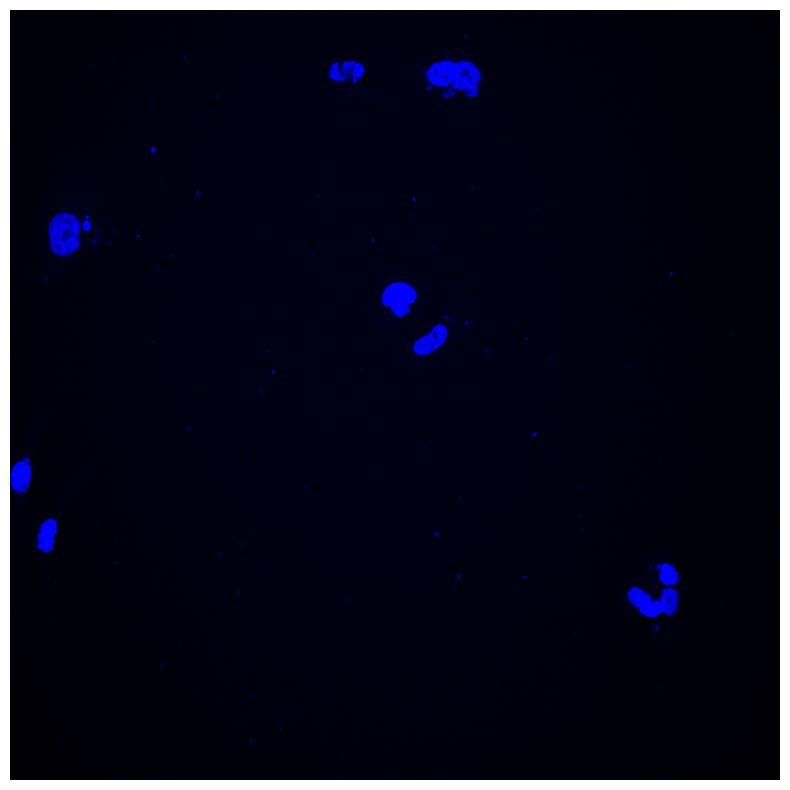

M03
downloaded file!


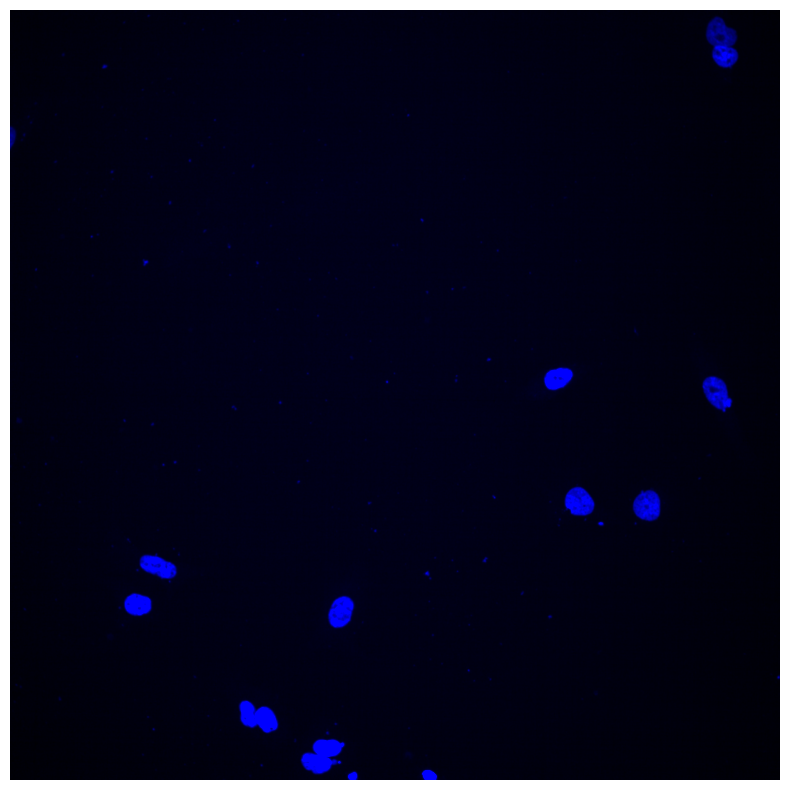

G07
downloaded file!


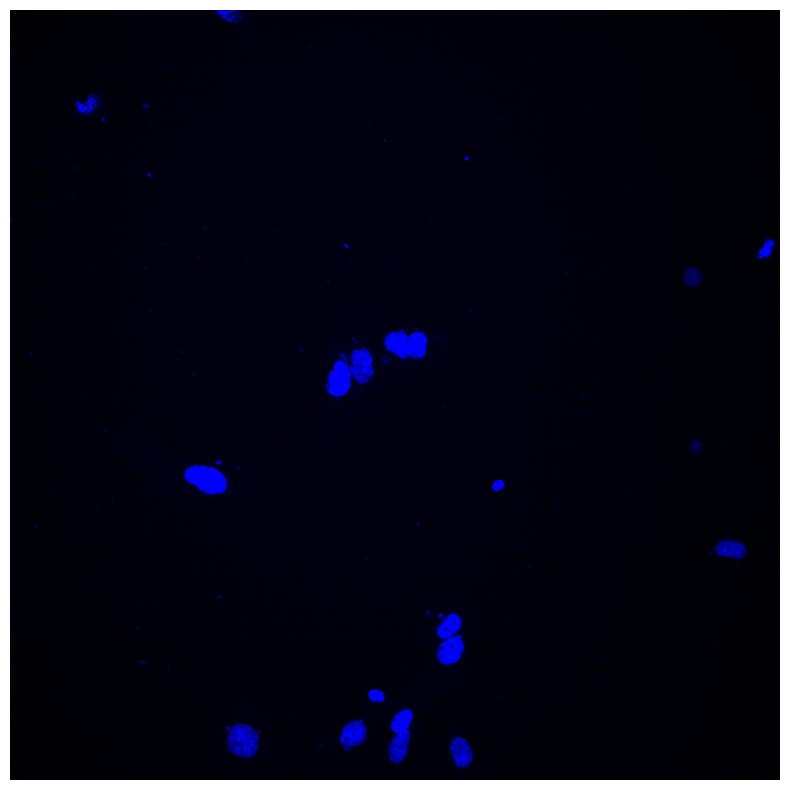

K07
downloaded file!


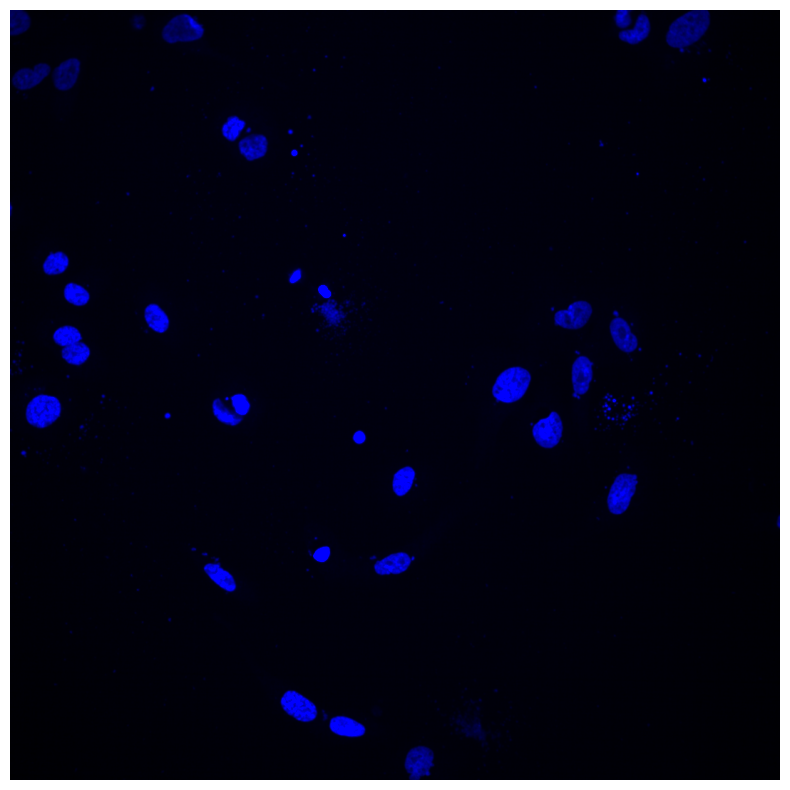

A09
downloaded file!


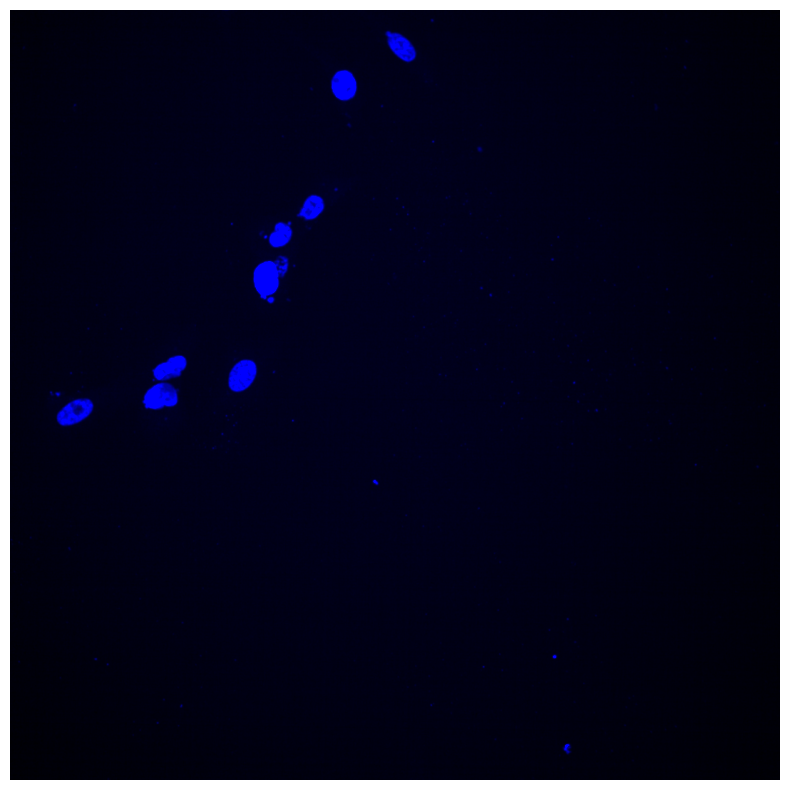

M11
downloaded file!


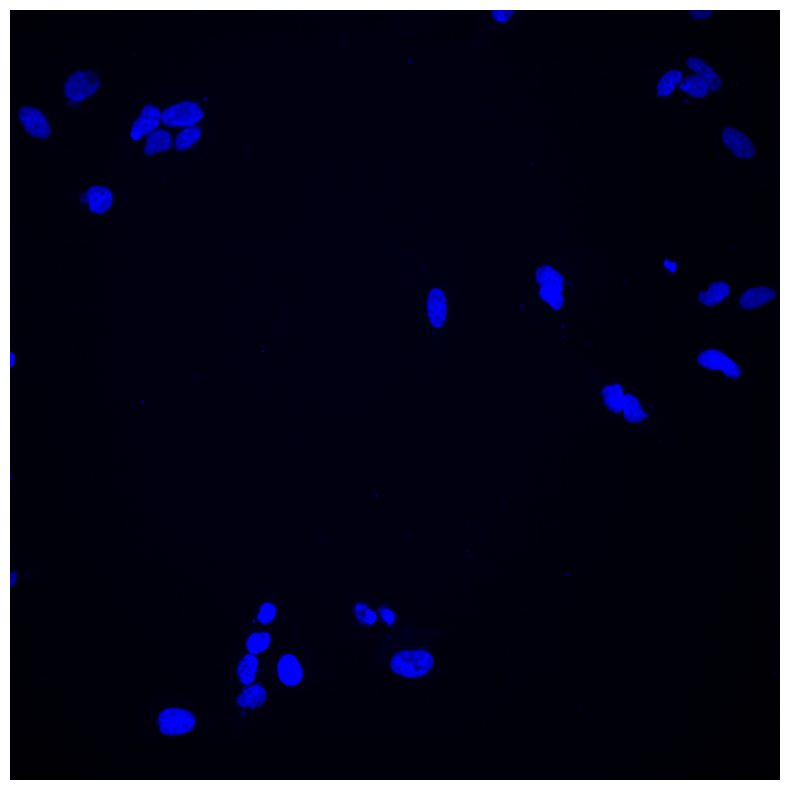

A13
downloaded file!


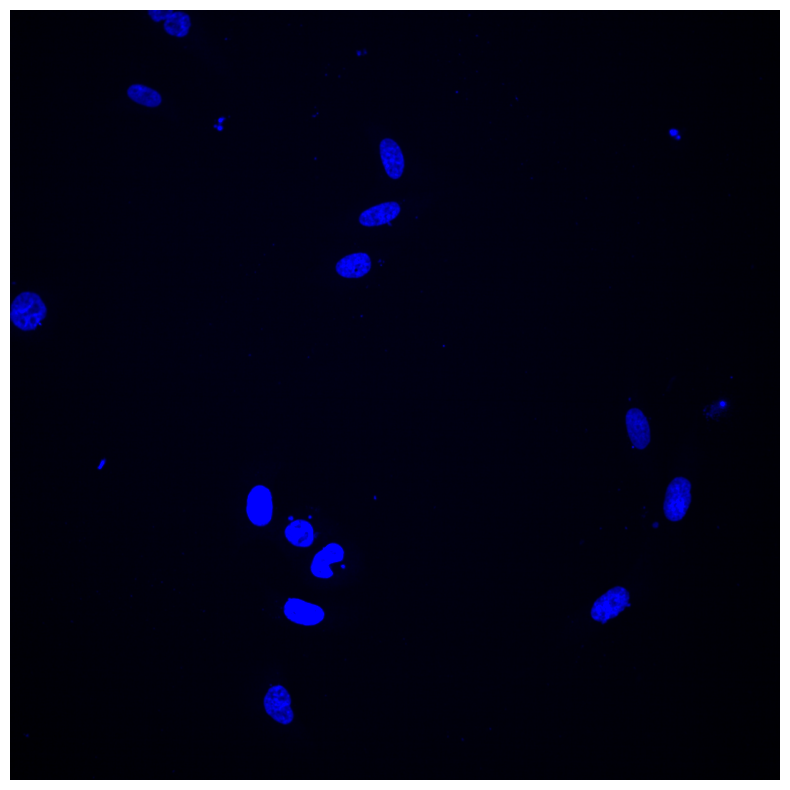

K13
downloaded file!


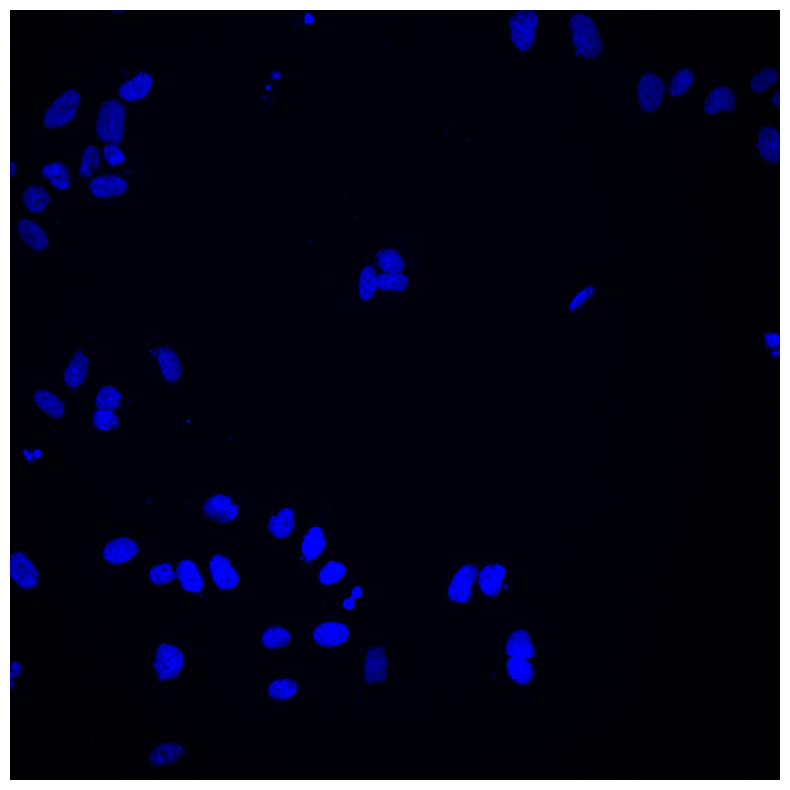

In [122]:
# Specify image parameters
sel_batch = "B6A3R2"
site = "05"
sel_channel = "DAPI"
sel_plate = "B6-P1T1"

slirp = ["G01", "M03", "G07", "K07", "A09", "M11", "A13", "K13"]
mapk = ["C15", "M01", "G03", "K05", "M07", "K09", "C13", "O13"]
prkacb = ["A01", "K03", "A05", "G05", "C07", "I07", "G11", "M15"]
rheb = ["C03", "E03", "A07", "E09", "A11", "O11", "A15", "M19"]
lpar1 = ["O01", "A03", "O03", "C05", "C11", "E11", "I11", "K11"]


var = lpar1


print("G01")
plotImages(sel_batch, sel_plate, site, var[0], sel_channel, 99.5)

print("M03")
plotImages(sel_batch, sel_plate, site, var[1], sel_channel, 99.5)

print("G07")
plotImages(sel_batch, sel_plate, site, var[2], sel_channel, 99.5)

print("K07")
plotImages(sel_batch, sel_plate, site, var[3], sel_channel, 99.5)

print("A09")
plotImages(sel_batch, sel_plate, site, var[4], sel_channel, 99.5)

print("M11")
plotImages(sel_batch, sel_plate, site, var[5], sel_channel, 99.5)

print("A13")
plotImages(sel_batch, sel_plate, site, var[6], sel_channel, 99.5)

print("K13")
plotImages(sel_batch, sel_plate, site, var[7], sel_channel, 99.5)